<a href="https://colab.research.google.com/github/KosukhaOlexandr/reactions_prediction/blob/main/reactions_prediction_model_without_stopwords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [39]:
import pandas as pd

with open('/content/drive/MyDrive/reaction_prediction/tsn_reactions_dataset.csv') as f:
  data = pd.read_csv(f, index_col = 0)
  
with open('/content/drive/My Drive/reaction_prediction/tsn_reactions_dataset_from_2_jul.csv') as f:
  data_from_2_jul = pd.read_csv(f, index_col = 0)

In [40]:
data = pd.concat([data.reset_index(drop=True), data_from_2_jul.reset_index(drop=True)], axis = 0)

In [41]:
pos_reacts = ['thumbs_up', 'thumbs_down', 'red_heart', 'fire', 'smiling_face_with_hearts', 'clapping_hands',
             'beaming_face_with_smiling_eyes', 'exploding_head', 'party_popper', 'star-struck']
neg_reacts = ['clown_face', 'thinking_face', 'face_screaming_in_fear', 'face_with_symbols_on_mouth', 'crying_face',
              'face_vomiting', 'pile_of_poo']

In [42]:
data['pos_sum'] = data[pos_reacts].sum(axis = 1)
data['neg_sum'] = data[neg_reacts].sum(axis = 1)
data.loc[:, ['pos_sum', 'neg_sum']]

,pos_sum,neg_sum
0,0.977353,0.022647
1,0.912266,0.087734
2,0.994040,0.005960
3,0.955475,0.044525
4,0.536110,0.463890
...,...,...
10136,0.072111,0.927889
10137,0.993582,0.006418
10138,0.996099,0.003901
10139,0.902312,0.097688


In [43]:
data.loc[:, ['pos_sum', 'neg_sum']] = data.loc[:, ['pos_sum', 'neg_sum']].applymap(lambda x: 1 if x > 0.5 else 0)

In [44]:
data.loc[:,['pos_sum','neg_sum']].sum(axis = 0)

pos_sum    13333
neg_sum     8122
dtype: int64

In [45]:
data['reaction_type'] = data['pos_sum']

In [46]:
data = data.loc[:, ['msg_text', 'reaction_type']]

In [47]:
with open('/content/drive/MyDrive/reaction_prediction/stopwords.txt') as f:
  stopwords = pd.read_table(f, header = None)

In [48]:
stopwords = stopwords.squeeze()

In [49]:
data['msg_text'] = data['msg_text'].apply(lambda x: ' '.join([w for w in x.split() if (w not in stopwords.values) and not w.isdigit()]))

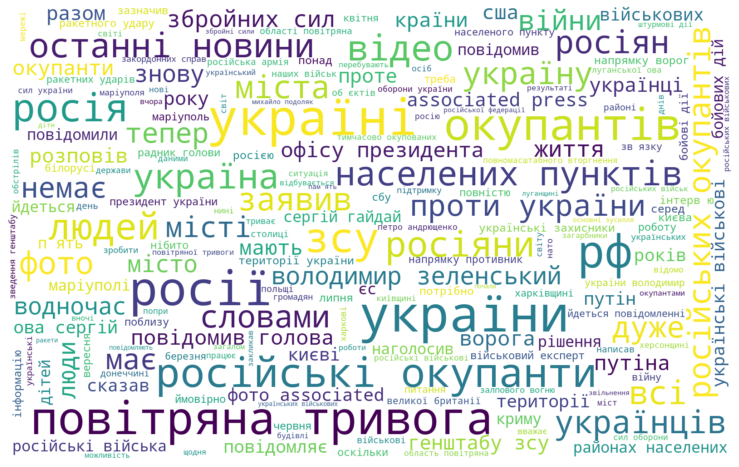

In [50]:
all_words = ' '.join([text for text in data['msg_text']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=1600, height=1000, random_state=21, background_color="white", max_font_size=110).generate(all_words)

import matplotlib.pyplot as plt

plt.figure(figsize=(13, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Wordcloud for positive reactions

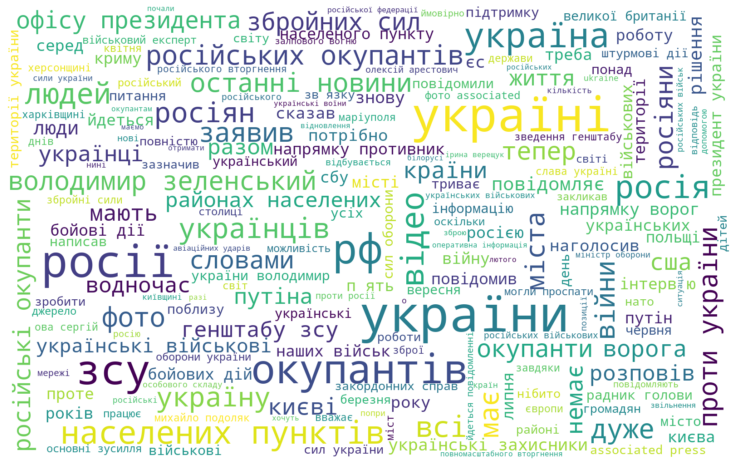

In [51]:
data_pos = data[data.reaction_type == 1]
all_words = ' '.join([text for text in data_pos['msg_text']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=1600, height=1000, random_state=21,
                      background_color="white", max_font_size=110,
                      relative_scaling = 0.6).generate(all_words)

import matplotlib.pyplot as plt

plt.figure(figsize=(13, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.savefig('pos_wordcloud.png')
plt.show()

Wordcloud for negative reactions

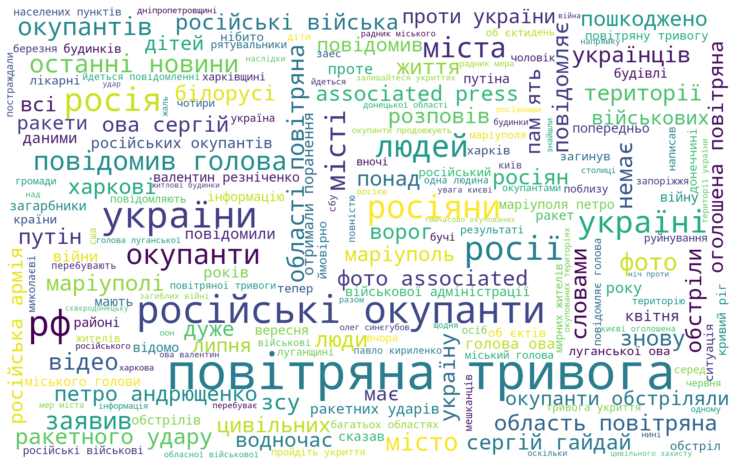

In [52]:
data_pos = data[data.reaction_type == 0]
all_words = ' '.join([text for text in data_pos['msg_text']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=1600, height=1000, random_state=21, background_color="white", max_font_size=110).generate(all_words)

import matplotlib.pyplot as plt

plt.figure(figsize=(13, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.savefig('neg_wordcloud.png')
plt.show()

Let's now build models using the stopwords extractioned version of the data

In [53]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
count_vec = CountVectorizer()
bow = count_vec.fit_transform(data.msg_text)
#bow = np.array(bow.todense())
bow

<21455x73699 sparse matrix of type '<class 'numpy.int64'>'
	with 622605 stored elements in Compressed Sparse Row format>

In [54]:
X = bow
Y = data.reaction_type

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, stratify = Y, random_state = 42)

In [56]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB(alpha = 0.01).fit(X_train, Y_train)

In [57]:
Y_pred_test = model.predict(X_test)
Y_pred_train = model.predict(X_train)

In [58]:
from sklearn.metrics import accuracy_score

print('Test set accuracy:', accuracy_score(Y_test, model.predict(X_test)))
print('Train set accuracy:', accuracy_score(Y_train, model.predict(X_train)))

Test set accuracy: 0.8087618455802392
Train set accuracy: 0.9609801571447596


In [59]:
from sklearn.metrics import f1_score

print('Test set F1 score:', f1_score(Y_test, Y_pred_test))
print('Train set F1 score:', f1_score(Y_train, Y_pred_train))

Test set F1 score: 0.8493821118316407
Train set F1 score: 0.968426724137931


In [60]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vec = TfidfVectorizer()
bow_ti = tf_idf_vec.fit_transform(data.msg_text)
#bow_ti = np.array(bow_ti.todense())
bow_ti

<21455x73699 sparse matrix of type '<class 'numpy.float64'>'
	with 622605 stored elements in Compressed Sparse Row format>

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

X = bow_ti
Y = data.reaction_type

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, stratify = Y, random_state = 42)

model = MultinomialNB(alpha = 0.01).fit(X_train, Y_train)

Y_pred = model.predict(X_test)
Y_pred_train = model.predict(X_train)

In [62]:
from sklearn.metrics import accuracy_score

print('Test set accuracy:', accuracy_score(Y_test, Y_pred))
print('Train set accuracy:', accuracy_score(Y_train, Y_pred_train))

Test set accuracy: 0.8157526798197918
Train set accuracy: 0.969503262751365


In [63]:
from sklearn.metrics import f1_score

print('Test set F1 score:', f1_score(Y_test, Y_pred))
print('Train set F1 score:', f1_score(Y_train, Y_pred_train))

Test set F1 score: 0.8591448931116389
Train set F1 score: 0.975578543244108


###SVC

In [64]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

X = bow_ti
Y = data.reaction_type

X_train_ti, X_test_ti, Y_train_ti, Y_test_ti = train_test_split(X, Y, test_size = 0.30, stratify = Y, random_state = 42)

svc_tf_idf = make_pipeline(StandardScaler(with_mean=False), SVC(C = 1, gamma='auto'))
svc_tf_idf.fit(X_train_ti, Y_train_ti)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('svc', SVC(C=1, gamma='auto'))])

In [65]:
Y_pred_test = svc_tf_idf.predict(X_test_ti)
Y_pred_train = svc_tf_idf.predict(X_train_ti)

In [66]:
from sklearn.metrics import accuracy_score

print('Test set accuracy:', accuracy_score(Y_test_ti, Y_pred_test))
print('Train set accuracy:', accuracy_score(Y_train_ti, Y_pred_train))

Test set accuracy: 0.7829734348298897
Train set accuracy: 0.9829537887867892


In [67]:
from sklearn.metrics import f1_score

print('Test set F1 score:', f1_score(Y_test_ti, Y_pred_test))
print('Train set F1 score:', f1_score(Y_train_ti, Y_pred_train))

Test set F1 score: 0.8482676224611708
Train set F1 score: 0.9863974495217853


In [74]:
X = bow
Y = data.reaction_type

In [75]:
X_train_cv, X_test_cv, Y_train_cv, Y_test_cv = train_test_split(X, Y, test_size = 0.30, stratify = Y, random_state=42)

svc_cv = make_pipeline(StandardScaler(with_mean=False), SVC(C = 1, gamma='auto'))
svc_cv.fit(X_train_cv, Y_train_cv)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('svc', SVC(C=1, gamma='auto'))])

In [76]:
Y_pred_test = svc_cv.predict(X_test_cv)
Y_pred_train = svc_cv.predict(X_train_cv)

In [77]:
print('Test set accuracy:', accuracy_score(Y_test_cv, Y_pred_test))
print('Train set accuracy:', accuracy_score(Y_train_cv, Y_pred_train))

print('Test set F1 score:', f1_score(Y_test_cv, Y_pred_test))
print('Train set F1 score:', f1_score(Y_train_cv, Y_pred_train))

Test set accuracy: 0.7882553984775517
Train set accuracy: 0.9670395525369556
Test set F1 score: 0.8514765173804076
Train set F1 score: 0.9740498034076015
